In [1]:
import nltk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import Counter
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')




In [2]:
path = '../Data_articles'
data_dirs = [x for x in os.listdir(path) if not x.startswith(".")]


In [3]:
articles = [json.load(open(os.path.join(path,data,d))) for data in data_dirs for d in os.listdir(os.path.join(path,data)) if d.endswith('.json')]


In [4]:

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

resources = ['punkt', 'stopwords', 'vader_lexicon', 'wordnet', 'averaged_perceptron_tagger','punkt_tab']

print("Descargando recursos de NLTK...")
for resource in resources:
    try:
        result = nltk.download(resource, quiet=True)
        if result:
            print(f"✅ {resource} - OK")
        else:
            print(f"ℹ️  {resource} - Ya existe")
    except Exception as e:
        print(f"❌ {resource} - Error: {e}")

print("Configuración de NLTK completada")


Descargando recursos de NLTK...
✅ punkt - OK
✅ stopwords - OK
✅ vader_lexicon - OK
✅ wordnet - OK
✅ averaged_perceptron_tagger - OK
✅ punkt_tab - OK
Configuración de NLTK completada


In [5]:

stop_words_es = stopwords.words('spanish')
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

In [6]:

print(f"Total de artículos: {len(articles)}")


Total de artículos: 18254


In [7]:
def clean_text(text):
    """
    Limpia y preprocessa el texto
    """
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    
    #text = re.sub(r'[^\w\s]', ' ', text)
    #text = re.sub(r'\d+', '', text)
    
    text = ' '.join(text.split())
    
    return text

def extract_text_from_articles(articles):
    """
    Extrae el texto de los artículos dependiendo de su estructura
    """
    texts = []
    for article in articles:
        if isinstance(article, dict):
            text_content = ""
            if 'text' in article:
                text_content = article['text']
            
            if text_content:
                texts.append(clean_text(text_content))
        elif isinstance(article, str):
            texts.append(clean_text(article))
    
    return [text for text in texts] 

clean_texts = extract_text_from_articles(articles)
print(f"Textos procesados: {len(clean_texts)}")


Textos procesados: 18250


## Análisis Básico de Texto

In [8]:

def basic_text_stats(texts):
    """
    Calcula estadísticas básicas de una colección de textos
    """
    all_text = ' '.join(texts)
    
    words = word_tokenize(all_text, language='spanish')
    sentences = sent_tokenize(all_text, language='spanish')
    
    words_no_stop = [word for word in words if word.lower() not in stop_words_es and len(word) > 2]
    
    stats = {
        'total_textos': len(texts),
        'total_caracteres': len(all_text),
        'total_palabras': len(words),
        'palabras_unicas': len(set(words)),
        'total_oraciones': len(sentences),
        'palabras_sin_stopwords': len(words_no_stop),
        'palabras_unicas_sin_stopwords': len(set(words_no_stop)),
        'promedio_palabras_por_texto': len(words) / len(texts) if texts else 0,
        'promedio_oraciones_por_texto': len(sentences) / len(texts) if texts else 0
    }
    
    return stats, words_no_stop

if clean_texts:
    stats, words_filtered = basic_text_stats(clean_texts)
    
    for key, value in stats.items():
        if isinstance(value, float):
            print(f"{key.replace('_', ' ').title()}: {value:.2f}")
        else:
            print(f"{key.replace('_', ' ').title()}: {value:,}")
else:
    print("No hay textos para analizar")

Total Textos: 18,250
Total Caracteres: 43,598,968
Total Palabras: 7,782,878
Palabras Unicas: 115,478
Total Oraciones: 224,595
Palabras Sin Stopwords: 3,685,645
Palabras Unicas Sin Stopwords: 114,507
Promedio Palabras Por Texto: 426.46
Promedio Oraciones Por Texto: 12.31


## Análisis de Frecuencia de Palabras

TOP 20 PALABRAS MÁS FRECUENTES:
presidente : 15837 veces
país : 15347 veces
gobierno : 14811 veces
venezuela : 12010 veces
nacional : 12001 veces
parte : 11920 veces
unidos : 9659 veces
personas : 9189 veces
gaza : 9015 veces
pueblo : 9011 veces
según : 8806 veces
acuerdo : 8224 veces
israel : 8178 veces
internacional : 7702 veces
países : 7632 veces
además : 7573 veces
seguridad : 7246 veces
años : 7242 veces
mientras : 7151 veces
tras : 6989 veces


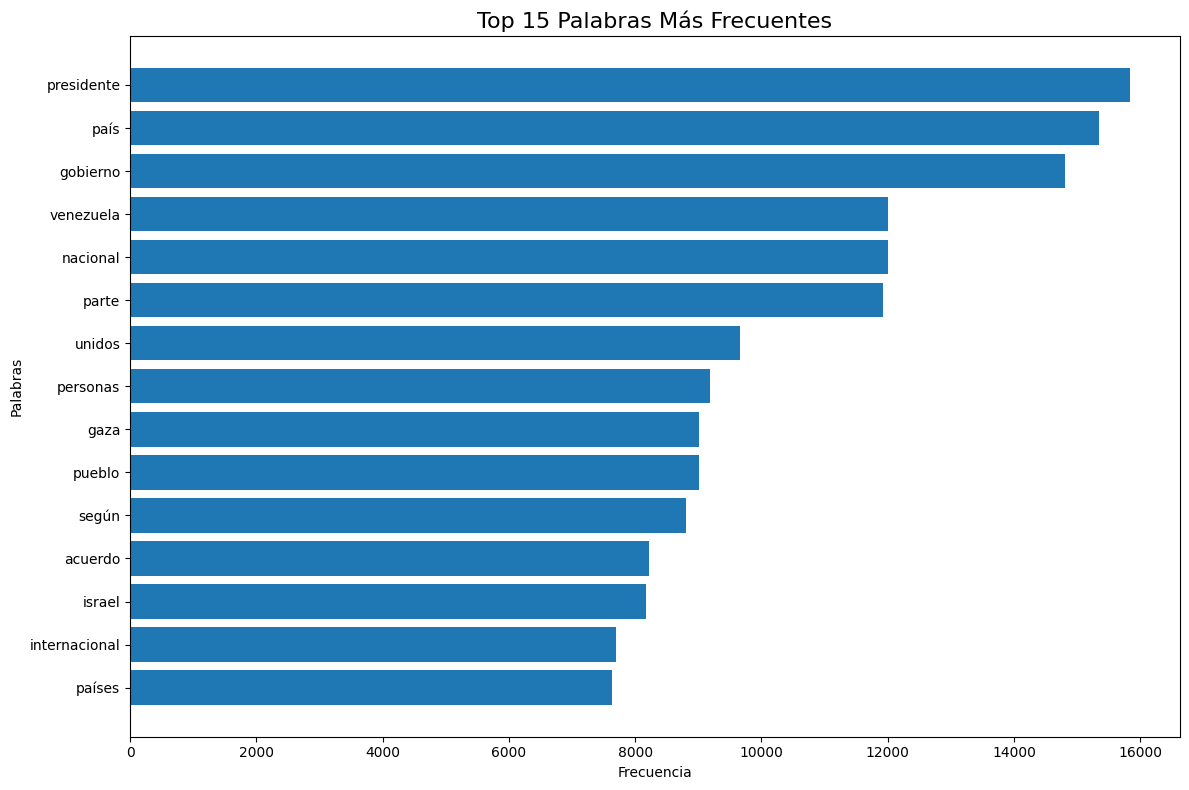


Vocabulario: 114507 palabras únicas


In [9]:

if clean_texts and 'words_filtered' in locals():
    word_freq = Counter(words_filtered)
    
    print("TOP 20 PALABRAS MÁS FRECUENTES:")
    for word, freq in word_freq.most_common(20):
        print(f"{word} : {freq} veces")
    
    top_words = dict(word_freq.most_common(15))
    
    plt.figure(figsize=(12, 8))
    plt.barh(list(top_words.keys())[::-1], list(top_words.values())[::-1])
    plt.title('Top 15 Palabras Más Frecuentes', fontsize=16)
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabras')
    plt.tight_layout()
    plt.show()
    
    print(f"\nVocabulario: {len(word_freq)} palabras únicas")

## Análisis de Sentimientos

In [10]:

def analyze_sentiment(texts):
    """
    Analiza el sentimiento de una colección de textos usando VADER
    """
    sentiments = []
    
    for i, text in enumerate(texts):
        
            scores = sia.polarity_scores(text)
            
            if scores['compound'] >= 0.05:
                sentiment = 'Positivo'
            elif scores['compound'] <= -0.05:
                sentiment = 'Negativo'
            else:
                sentiment = 'Neutral'
            
            sentiments.append({
                'texto_id': i,
                'sentimiento': sentiment,
                'compound': scores['compound'],
                'positive': scores['pos'],
                'neutral': scores['neu'],
                'negative': scores['neg']
            })
    
    return sentiments

if clean_texts:
    sentiment_results = analyze_sentiment(clean_texts)
    
    sentiment_counts = Counter([s['sentimiento'] for s in sentiment_results])
    
    print("ANÁLISIS DE SENTIMIENTOS:")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(sentiment_results)) * 100
        print(f"{sentiment:<10}: {count:>3} textos ({percentage:.1f}%)")
    
    compound_scores = [s['compound'] for s in sentiment_results]
    print(f"\nESTADÍSTICAS DE COMPOUND SCORE:")
    print(f"Promedio: {np.mean(compound_scores):.3f}")
    print(f"Mediana: {np.median(compound_scores):.3f}")
    print(f"Desviación estándar: {np.std(compound_scores):.3f}")
    print(f"Mínimo: {np.min(compound_scores):.3f}")
    print(f"Máximo: {np.max(compound_scores):.3f}")

ANÁLISIS DE SENTIMIENTOS:
Positivo  : 5909 textos (32.4%)
Negativo  : 10275 textos (56.3%)
Neutral   : 2066 textos (11.3%)

ESTADÍSTICAS DE COMPOUND SCORE:
Promedio: -0.191
Mediana: -0.273
Desviación estándar: 0.545
Mínimo: -0.998
Máximo: 0.995


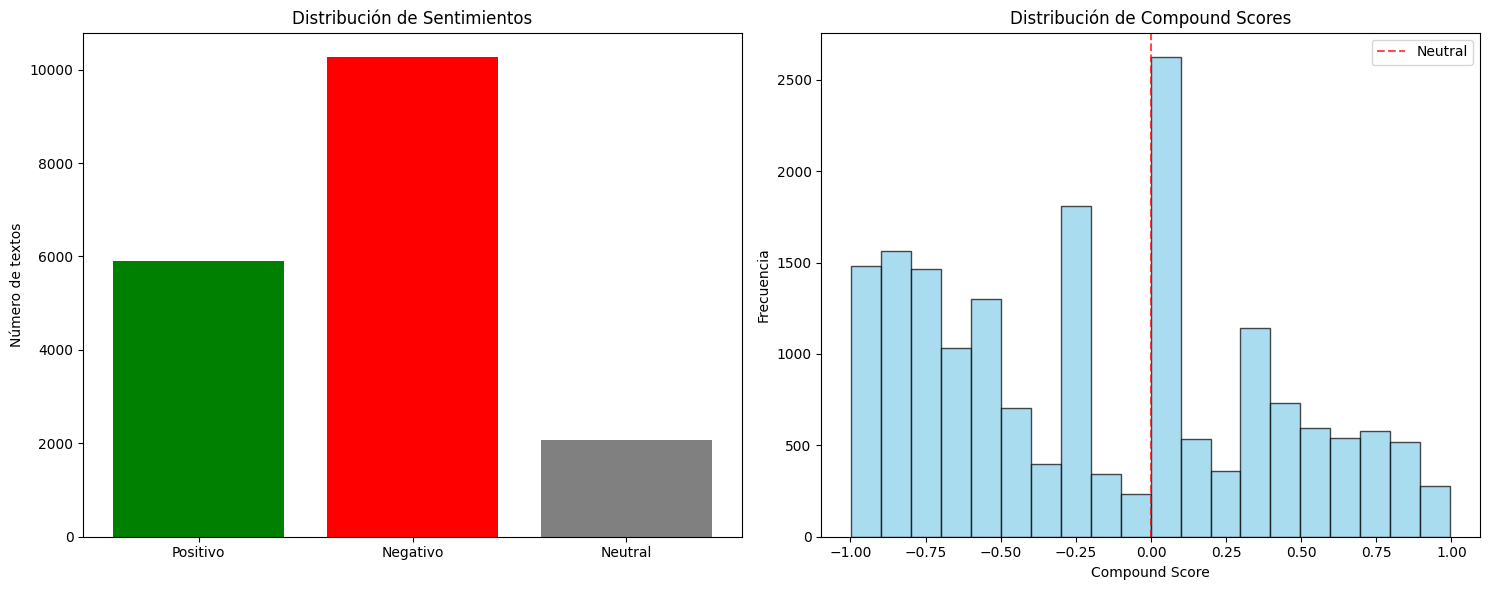

In [11]:

if clean_texts and 'sentiment_results' in locals():

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sentiments = list(sentiment_counts.keys())
    counts = list(sentiment_counts.values())
    colors = ['green' if s == 'Positivo' else 'red' if s == 'Negativo' else 'gray' for s in sentiments]
    
    ax1.bar(sentiments, counts, color=colors)
    ax1.set_title('Distribución de Sentimientos')
    ax1.set_ylabel('Número de textos')
    
    ax2.hist([s['compound'] for s in sentiment_results], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_title('Distribución de Compound Scores')
    ax2.set_xlabel('Compound Score')
    ax2.set_ylabel('Frecuencia')
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## Análisis de N-gramas

ANÁLISIS DE N-GRAMAS:

TOP 10 BIGRAMAS:
------------------------------
nicolás maduro            : 3201 veces
franja gaza               : 2985 veces
donald trump              : 2615 veces
derechos humanos          : 2507 veces
naciones unidas           : 2362 veces
primer ministro           : 1876 veces
millones dólares          : 1699 veces
alto fuego                : 1607 veces
redes sociales            : 1571 veces
américa latina            : 1547 veces

TOP 10 TRIGRAMAS:
------------------------------
presidente nicolás maduro           : 1178 veces
venezuela nicolás maduro            : 854 veces
presidente venezuela nicolás        : 688 veces
américa latina caribe               : 638 veces
consejo nacional electoral          : 578 veces
organización naciones unidas        : 548 veces
república bolivariana venezuela     : 482 veces
naciones unidas onu                 : 462 veces
estadounidense donald trump         : 458 veces
presidente donald trump             : 452 veces


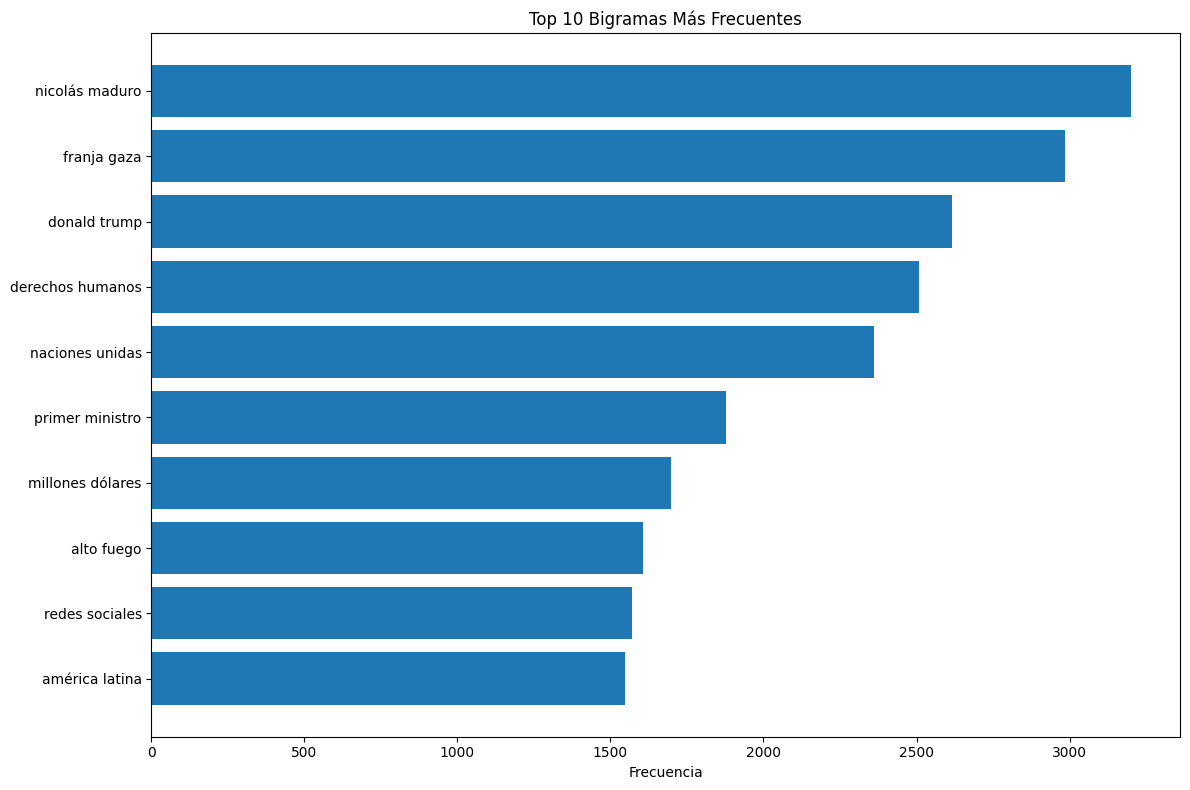

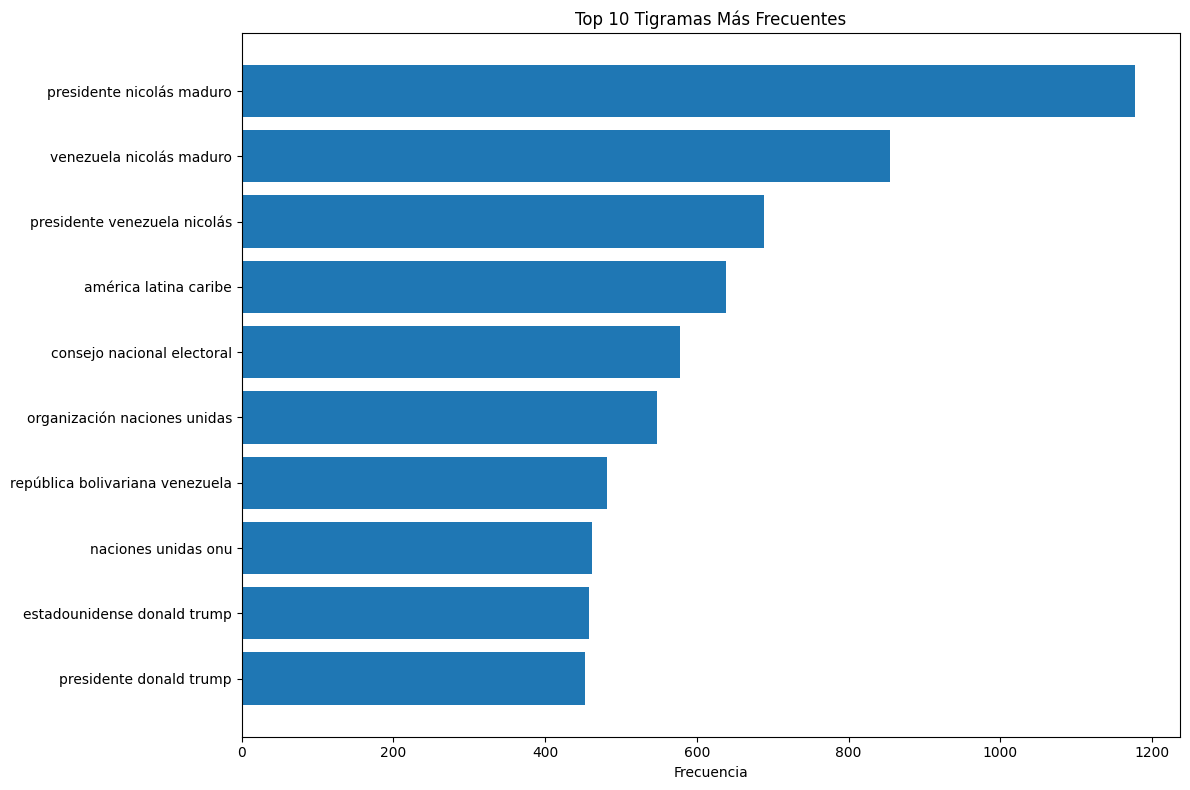

In [12]:

def analyze_ngrams(words, n=2, top_n=10):
    """
    Analiza n-gramas en una lista de palabras
    """
    n_grams = list(ngrams(words, n))
    n_gram_freq = Counter(n_grams)
    return n_gram_freq.most_common(top_n)

if clean_texts and 'words_filtered' in locals():
    print("ANÁLISIS DE N-GRAMAS:")
    print("="*50)
    
    bigrams = analyze_ngrams(words_filtered, n=2, top_n=10)
    print("\nTOP 10 BIGRAMAS:")
    print("-" * 30)
    for bigram, freq in bigrams:
        print(f"{' '.join(bigram):<25} : {freq:>3} veces")
    
    trigrams = analyze_ngrams(words_filtered, n=3, top_n=10)
    print("\nTOP 10 TRIGRAMAS:")
    print("-" * 30)
    for trigram, freq in trigrams:
        print(f"{' '.join(trigram):<35} : {freq:>3} veces")
    
    if bigrams:
        bigram_labels = [' '.join(bg[0]) for bg in bigrams[:10]]
        bigram_counts = [bg[1] for bg in bigrams[:10]]
        
        plt.figure(figsize=(12, 8))
        plt.barh(bigram_labels[::-1], bigram_counts[::-1])
        plt.title('Top 10 Bigramas Más Frecuentes')
        plt.xlabel('Frecuencia')
        plt.tight_layout()
        plt.show()
    if trigrams:
        trigrams_labels = [' '.join(bg[0]) for bg in trigrams[:10]]
        trigrams_counts = [bg[1] for bg in trigrams[:10]]
        
        plt.figure(figsize=(12, 8))
        plt.barh(trigrams_labels[::-1], trigrams_counts[::-1])
        plt.title('Top 10 Tigramas Más Frecuentes')
        plt.xlabel('Frecuencia')
        plt.tight_layout()
        plt.show()

## Análisis de Longitud de Textos y Oraciones

ANÁLISIS DE LONGITUDES:
TEXTOS (palabras):
  Promedio: 378.1 palabras
  Mediana: 330.0 palabras
  Mínimo: 0 palabras
  Máximo: 11036 palabras
  Desv. estándar: 258.0

TEXTOS (caracteres):
  Promedio: 2388 caracteres
  Mediana: 2084 caracteres
  Mínimo: 0 caracteres
  Máximo: 68427 caracteres

ORACIONES:
  Total de oraciones: 225451
  Promedio: 34.5 palabras por oración
  Mediana: 32.0 palabras por oración
  Mínimo: 1 palabras
  Máximo: 451 palabras


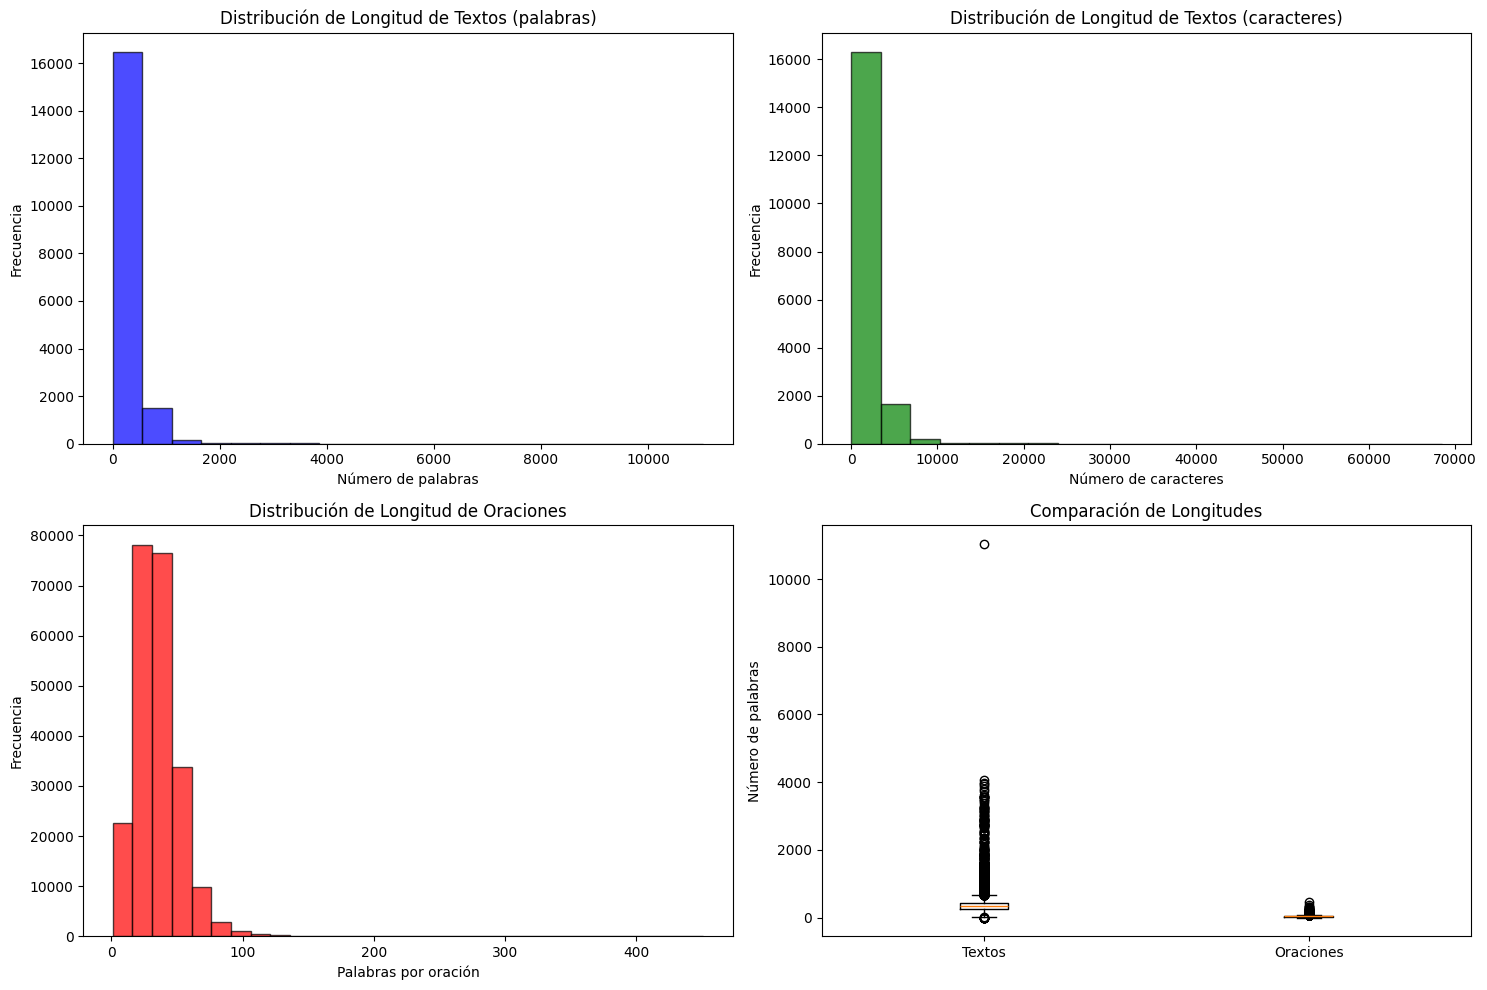

In [13]:

if clean_texts:
    text_lengths = [len(text.split()) for text in clean_texts]
    char_lengths = [len(text) for text in clean_texts]
    
    sentence_lengths = []
    for text in clean_texts:
        sentences = sent_tokenize(text, language='spanish')
        for sentence in sentences:
            words_in_sentence = len(word_tokenize(sentence, language='spanish'))
            if words_in_sentence > 0:
                sentence_lengths.append(words_in_sentence)
    
    print("ANÁLISIS DE LONGITUDES:")
    print("="*50)
    print(f"TEXTOS (palabras):")
    print(f"  Promedio: {np.mean(text_lengths):.1f} palabras")
    print(f"  Mediana: {np.median(text_lengths):.1f} palabras")
    print(f"  Mínimo: {np.min(text_lengths)} palabras")
    print(f"  Máximo: {np.max(text_lengths)} palabras")
    print(f"  Desv. estándar: {np.std(text_lengths):.1f}")
    
    print(f"\nTEXTOS (caracteres):")
    print(f"  Promedio: {np.mean(char_lengths):.0f} caracteres")
    print(f"  Mediana: {np.median(char_lengths):.0f} caracteres")
    print(f"  Mínimo: {np.min(char_lengths)} caracteres")
    print(f"  Máximo: {np.max(char_lengths)} caracteres")
    
    if sentence_lengths:
        print(f"\nORACIONES:")
        print(f"  Total de oraciones: {len(sentence_lengths)}")
        print(f"  Promedio: {np.mean(sentence_lengths):.1f} palabras por oración")
        print(f"  Mediana: {np.median(sentence_lengths):.1f} palabras por oración")
        print(f"  Mínimo: {np.min(sentence_lengths)} palabras")
        print(f"  Máximo: {np.max(sentence_lengths)} palabras")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0,0].hist(text_lengths, bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0,0].set_title('Distribución de Longitud de Textos (palabras)')
    axes[0,0].set_xlabel('Número de palabras')
    axes[0,0].set_ylabel('Frecuencia')
    
    axes[0,1].hist(char_lengths, bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[0,1].set_title('Distribución de Longitud de Textos (caracteres)')
    axes[0,1].set_xlabel('Número de caracteres')
    axes[0,1].set_ylabel('Frecuencia')
    
 
    if sentence_lengths:
        axes[1,0].hist(sentence_lengths, bins=30, alpha=0.7, color='red', edgecolor='black')
        axes[1,0].set_title('Distribución de Longitud de Oraciones')
        axes[1,0].set_xlabel('Palabras por oración')
        axes[1,0].set_ylabel('Frecuencia')
    
    box_data = [text_lengths, sentence_lengths[:len(text_lengths)] if sentence_lengths else []]
    axes[1,1].boxplot([text_lengths, sentence_lengths if sentence_lengths else [0]], 
                      labels=['Textos', 'Oraciones'])
    axes[1,1].set_title('Comparación de Longitudes')
    axes[1,1].set_ylabel('Número de palabras')
    
    plt.tight_layout()
    plt.show()

## Análisis de Diversidad Léxica y Complejidad

ANÁLISIS DE DIVERSIDAD LÉXICA:
Total de palabras: 4,773,644
Palabras únicas: 95,345
Type-Token Ratio (TTR): 0.0200
Índice de Simpson (diversidad): 0.9962
Longitud promedio de palabras: 6.62 caracteres
Interpretación TTR: Baja diversidad léxica


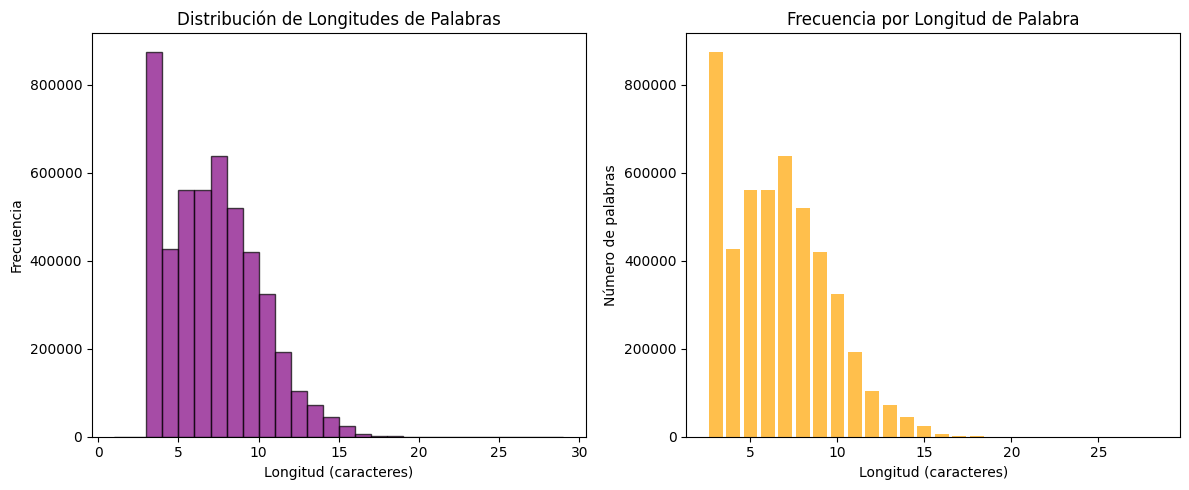

In [14]:

def calculate_lexical_diversity(texts):
    """
    Calcula métricas de diversidad léxica
    """
    all_text = ' '.join(texts)
    words = word_tokenize(all_text.lower(), language='spanish')
    words_clean = [w for w in words if w.isalpha() and len(w) > 2]
    
    total_words = len(words_clean)
    unique_words = len(set(words_clean))
    
    ttr = unique_words / total_words if total_words > 0 else 0
    
    word_freq = Counter(words_clean)
    n = sum(word_freq.values())
    simpson_index = sum((freq * (freq - 1)) for freq in word_freq.values()) / (n * (n - 1)) if n > 1 else 0
    simpson_diversity = 1 - simpson_index
    
    word_lengths = [len(word) for word in words_clean]
    avg_word_length = np.mean(word_lengths)
    
    return {
        'total_words': total_words,
        'unique_words': unique_words,
        'ttr': ttr,
        'simpson_diversity': simpson_diversity,
        'avg_word_length': avg_word_length,
        'word_lengths': word_lengths
    }

if clean_texts:
    lexical_stats = calculate_lexical_diversity(clean_texts)
    
    print("ANÁLISIS DE DIVERSIDAD LÉXICA:")
    print("="*50)
    print(f"Total de palabras: {lexical_stats['total_words']:,}")
    print(f"Palabras únicas: {lexical_stats['unique_words']:,}")
    print(f"Type-Token Ratio (TTR): {lexical_stats['ttr']:.4f}")
    print(f"Índice de Simpson (diversidad): {lexical_stats['simpson_diversity']:.4f}")
    print(f"Longitud promedio de palabras: {lexical_stats['avg_word_length']:.2f} caracteres")
    
    if lexical_stats['ttr'] > 0.7:
        interpretation = "Muy alta diversidad léxica"
    elif lexical_stats['ttr'] > 0.5:
        interpretation = "Alta diversidad léxica"
    elif lexical_stats['ttr'] > 0.3:
        interpretation = "Diversidad léxica moderada"
    else:
        interpretation = "Baja diversidad léxica"
    
    print(f"Interpretación TTR: {interpretation}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(lexical_stats['word_lengths'], bins=range(1, max(lexical_stats['word_lengths'])+2), 
             alpha=0.7, color='purple', edgecolor='black')
    plt.title('Distribución de Longitudes de Palabras')
    plt.xlabel('Longitud (caracteres)')
    plt.ylabel('Frecuencia')
    
    plt.subplot(1, 2, 2)
    length_counts = Counter(lexical_stats['word_lengths'])
    lengths = sorted(length_counts.keys())
    counts = [length_counts[l] for l in lengths]
    plt.bar(lengths, counts, alpha=0.7, color='orange')
    plt.title('Frecuencia por Longitud de Palabra')
    plt.xlabel('Longitud (caracteres)')
    plt.ylabel('Número de palabras')
    
    plt.tight_layout()
    plt.show()

##  Análisis Temporal de Contenido

ANÁLISIS TEMPORAL Y POR CATEGORÍAS:

DISTRIBUCIÓN POR SECCIONES:
América Latina y El Caribe: 9394 artículos,  374.2 palabras promedio
Mundo                    : 8039 artículos,  341.4 palabras promedio
En profundidad           :  265 artículos, 1547.5 palabras promedio
Deporte                  :  204 artículos,  307.2 palabras promedio
Cultura                  :  149 artículos,  351.2 palabras promedio
                         :   81 artículos, 1050.2 palabras promedio
Tecnología               :   61 artículos,  294.7 palabras promedio
Sin categoría            :   50 artículos,  235.7 palabras promedio
Lo mejor                 :    4 artículos,   56.5 palabras promedio
Video                    :    3 artículos,  112.3 palabras promedio


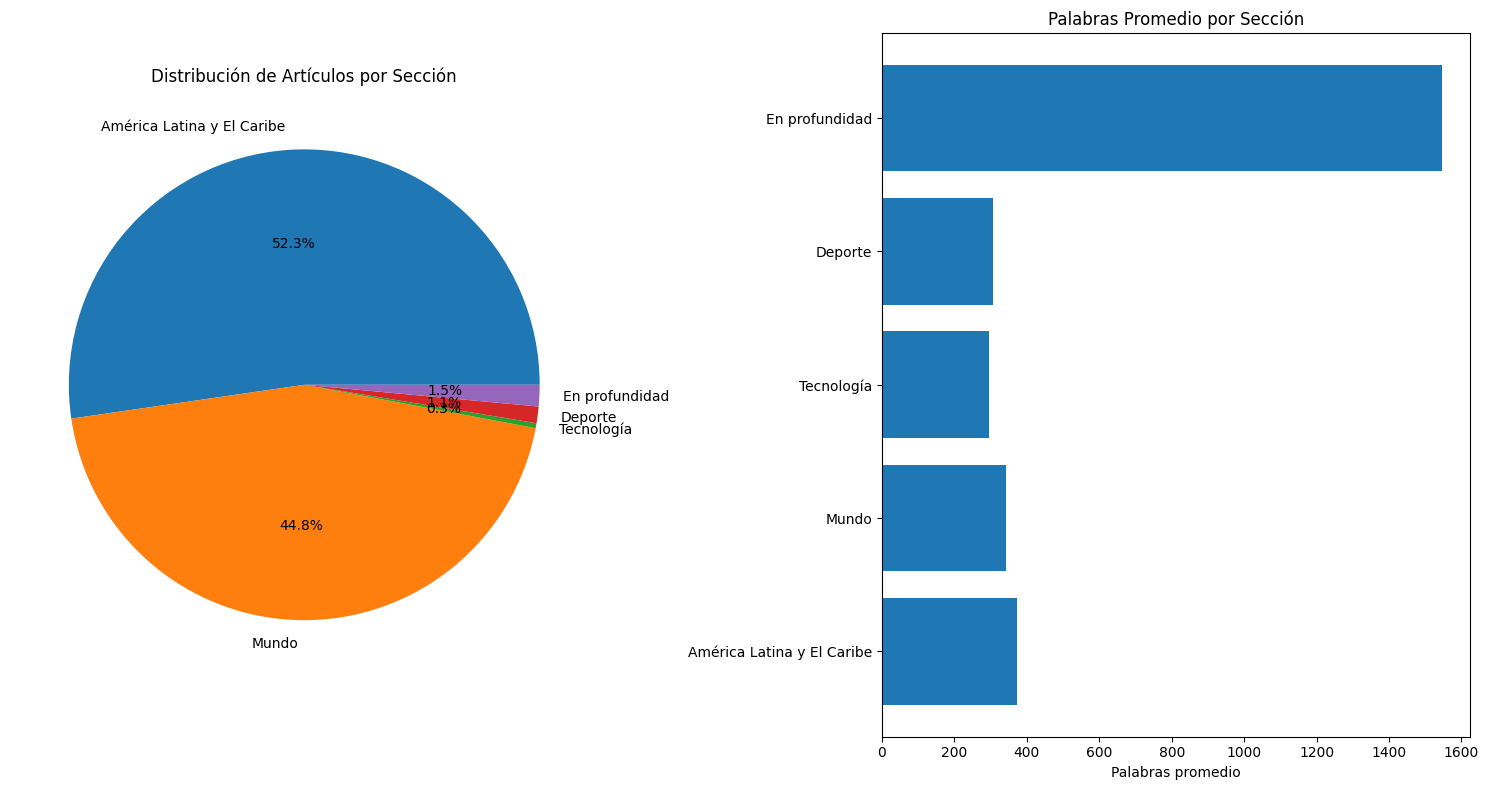

In [15]:

def analyze_temporal_patterns():
    """
    Analiza patrones temporales en el contenido de los artículos
    """
    temporal_data = []
    
    for article in articles:
        if isinstance(article, dict) and 'source_metadata' in article:
            metadata = article.get('source_metadata', {})
            date = metadata.get('date')
            text = article.get('text', '')
            
            if date and text:
                temporal_data.append({
                    'date': date,
                    'text_length': len(text.split()),
                    'char_length': len(text),
                    'text': text[:100] + "..." if len(text) > 100 else text
                })
    
    return temporal_data

def analyze_by_section():
    """
    Analiza el contenido por secciones
    """
    section_analysis = {}
    
    for article in articles:
        if isinstance(article, dict):
            section = article.get('section', 'Sin categoría')
            text = article.get('text', '')
            
            if section not in section_analysis:
                section_analysis[section] = {
                    'count': 0,
                    'total_words': 0,
                    'texts': []
                }
            
            section_analysis[section]['count'] += 1
            section_analysis[section]['total_words'] += len(text.split())
            section_analysis[section]['texts'].append(text)
    
    return section_analysis

print("ANÁLISIS TEMPORAL Y POR CATEGORÍAS:")
print("="*50)

section_stats = analyze_by_section()

print("\nDISTRIBUCIÓN POR SECCIONES:")
for section, data in sorted(section_stats.items(), key=lambda x: x[1]['count'], reverse=True):
    avg_words = data['total_words'] / data['count'] if data['count'] > 0 else 0
    print(f"{section:<25}: {data['count']:>4} artículos, {avg_words:>6.1f} palabras promedio")

if section_stats:
    sections = list(section_stats.keys())[:5] 
    counts = [section_stats[s]['count'] for s in sections]
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 2, 1)
    plt.pie(counts, labels=sections, autopct='%1.1f%%')
    plt.title('Distribución de Artículos por Sección')
    
    plt.subplot(1, 2, 2)
    avg_words_by_section = [section_stats[s]['total_words']/section_stats[s]['count'] 
                           for s in sections]
    plt.barh(sections, avg_words_by_section)
    plt.title('Palabras Promedio por Sección')
    plt.xlabel('Palabras promedio')
    
    plt.tight_layout()
    plt.show()

## Análisis de Clustering 

ANÁLISIS DE CLUSTERING (TF-IDF + K-MEANS):


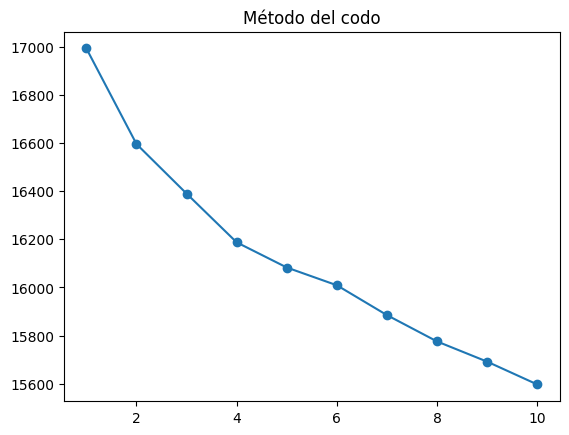

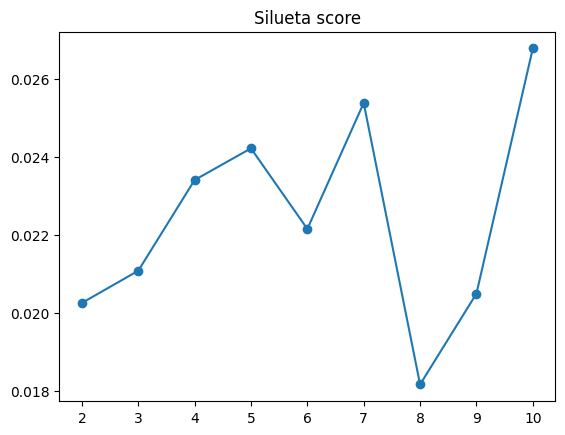


CLUSTER 1:
  Tamaño: 1570 textos
  Términos clave: trump, unidos, ee uu, uu, ee

CLUSTER 2:
  Tamaño: 1873 textos
  Términos clave: cuba, china, brics, países, cooperación

CLUSTER 3:
  Tamaño: 7988 textos
  Términos clave: gobierno, nacional, personas, país, ciento

CLUSTER 4:
  Tamaño: 996 textos
  Términos clave: rusia, ucrania, ruso, putin, kiev

CLUSTER 5:
  Tamaño: 1962 textos
  Términos clave: gaza, israel, palestinos, franja, israelí

CLUSTER 6:
  Tamaño: 2507 textos
  Términos clave: venezuela, maduro, venezolano, nicolás, nicolás maduro

CLUSTER 7:
  Tamaño: 1354 textos
  Términos clave: irán, israel, líbano, ataques, israelí


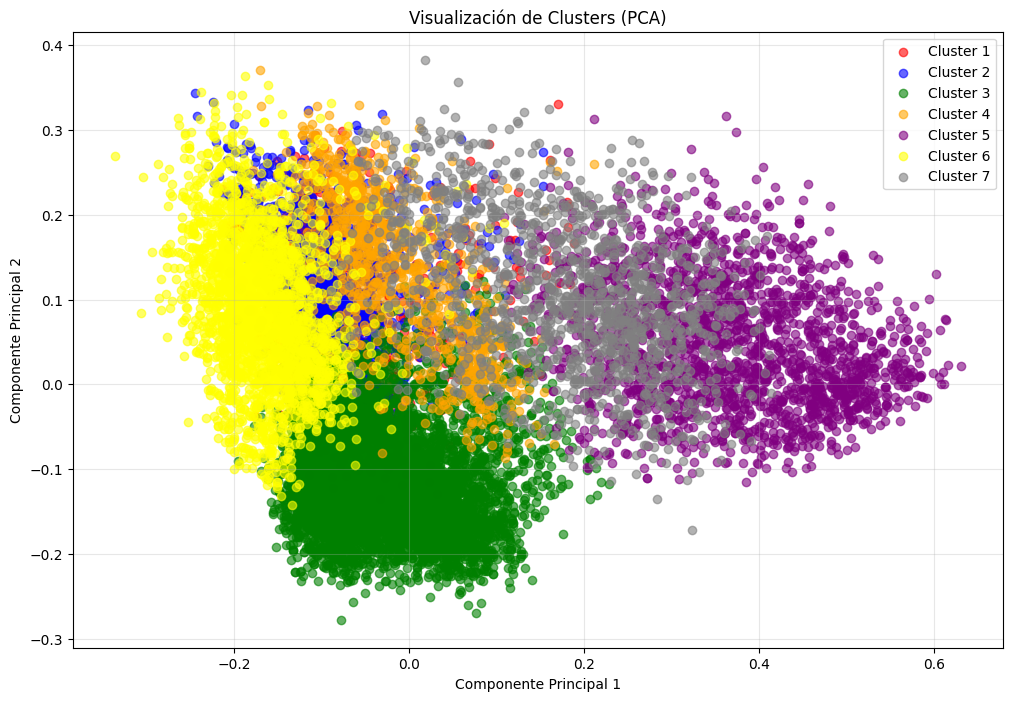

In [20]:

def perform_clustering_analysis(texts, n_clusters=5, max_features=1000):
    """
    Realiza análisis de clustering usando TF-IDF y K-means
    """
    
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words=stop_words_es,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )
    
    sample_texts = texts[:]
    
    tfidf_matrix = vectorizer.fit_transform(sample_texts)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    
    feature_names = vectorizer.get_feature_names_out()
    cluster_centers = kmeans.cluster_centers_
    
    clusters_info = {}
    for i in range(n_clusters):
        center = cluster_centers[i]
        top_indices = center.argsort()[-10:][::-1]
        top_terms = [feature_names[idx] for idx in top_indices]

        cluster_texts = [sample_texts[j] for j, label in enumerate(cluster_labels) if label == i]
        
        clusters_info[i] = {
            'size': len(cluster_texts),
            'top_terms': top_terms,
            'sample_texts': cluster_texts[:3]  
        }
    
    return clusters_info, cluster_labels, tfidf_matrix

if len(clean_texts) > 10:
    print("ANÁLISIS DE CLUSTERING (TF-IDF + K-MEANS):")
    print("="*60)
    
    try:
        sse = []
        k_range = range(1,11)
        vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words=stop_words_es,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )
        sc = []
        sample_texts = clean_texts[:]
        tfidf_matrix = vectorizer.fit_transform(sample_texts)
        for k in k_range:
            km = KMeans(n_clusters=k)
            l = km.fit_predict(tfidf_matrix)
            sse.append(km.inertia_)
            if k>1:
                a= silhouette_score(tfidf_matrix,l)
                sc.append(a)

        plt.plot(k_range,sse,marker='o')
        plt.title("Método del codo")
        plt.show()
        plt.plot(range(2,11),sc,marker='o')
        plt.title("Silueta score")
        plt.show()
        clusters_info, cluster_labels, tfidf_matrix = perform_clustering_analysis(clean_texts, n_clusters=7)
        
        for cluster_id, info in clusters_info.items():
            print(f"\nCLUSTER {cluster_id + 1}:")
            print(f"  Tamaño: {info['size']} textos")
            print(f"  Términos clave: {', '.join(info['top_terms'][:5])}")

        if tfidf_matrix.shape[0] > 5:
            pca = PCA(n_components=2, random_state=42)
            coords = pca.fit_transform(tfidf_matrix.toarray())
            
            plt.figure(figsize=(12, 8))
            colors = ['red', 'blue', 'green', 'orange', 'purple','yellow','gray','black']
            
            for i in range(max(cluster_labels) + 1):
                cluster_coords = coords[cluster_labels == i]
                if len(cluster_coords) > 0:
                    plt.scatter(cluster_coords[:, 0], cluster_coords[:, 1], 
                              c=colors[i % len(colors)], label=f'Cluster {i+1}', alpha=0.6)
            
            plt.title('Visualización de Clusters (PCA)')
            plt.xlabel('Componente Principal 1')
            plt.ylabel('Componente Principal 2')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    except Exception as e:
        print(f"Error en clustering: {e}")

else:
    print("⚠️  Necesitas más textos para realizar clustering (mínimo 10)")


## Modelado de Temas 

In [ ]:

def prepare_text_for_lda(text):
    words = word_tokenize(text.lower(), language='spanish')
    return ' '.join([word for word in words if word.isalnum() and word not in stop_words_es])

texts_for_lda = [prepare_text_for_lda(text) for text in clean_texts]

cv_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),
    token_pattern=r'[a-záéíóúñü]{3,}'
)

cv_matrix = cv_vectorizer.fit_transform(texts_for_lda)
feature_names = cv_vectorizer.get_feature_names_out()

n_topics_options = [5, 8, 10, 15]
best_coherence = -float('inf')
best_n_topics = 5


for n_topics in n_topics_options:
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=10,
        learning_method='online'
    )
    lda.fit(cv_matrix)
    
    
    perplexity = lda.perplexity(cv_matrix)
    print(f"  {n_topics} temas: Perplexity = {perplexity:.2f}")
    
    if perplexity < best_coherence or best_coherence == -float('inf'):
        best_coherence = perplexity
        best_n_topics = n_topics

print(f"\nMejor número de temas: {best_n_topics}")


final_lda = LatentDirichletAllocation(
    n_components=best_n_topics,
    random_state=42,
    max_iter=20,
    learning_method='online'
)

lda_topics = final_lda.fit_transform(cv_matrix)

def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-no_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[f"Tema {topic_idx + 1}"] = top_words
    return topics

topics_dict = display_topics(final_lda, feature_names, 8)

for topic_name, words in topics_dict.items():
    print(f"{topic_name}: {', '.join(words)}")

doc_topic_probs = final_lda.transform(cv_matrix)
dominant_topics = np.argmax(doc_topic_probs, axis=1)
topic_counts = Counter(dominant_topics)


for topic_id in range(best_n_topics):
    count = topic_counts[topic_id]
    percentage = (count / len(dominant_topics)) * 100
    print(f"Tema {topic_id + 1}: {count} documentos ({percentage:.1f}%)")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


topic_labels = [f'Tema {i+1}' for i in range(best_n_topics)]
topic_values = [topic_counts[i] for i in range(best_n_topics)]

ax1.bar(topic_labels, topic_values, color=plt.cm.Set3(np.linspace(0, 1, best_n_topics)))
ax1.set_title('Distribución de Documentos por Tema')
ax1.set_ylabel('Número de Documentos')
ax1.tick_params(axis='x', rotation=45)


topic_word_matrix = final_lda.components_
top_words_per_topic = []
top_word_names = []

for topic_idx in range(best_n_topics):
    top_words_idx = topic_word_matrix[topic_idx].argsort()[-10:][::-1]
    topic_words = [feature_names[i] for i in top_words_idx]
    top_words_per_topic.append(topic_word_matrix[topic_idx][top_words_idx])
    if topic_idx == 0:  
        top_word_names = topic_words

heatmap_data = np.array(top_words_per_topic)

sns.heatmap(heatmap_data, 
           xticklabels=top_word_names,
           yticklabels=[f'Tema {i+1}' for i in range(best_n_topics)],
           cmap='YlOrRd',
           ax=ax2)
ax2.set_title('Intensidad de Palabras por Tema')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


for topic_id in range(min(3, best_n_topics)):  
    topic_docs = [i for i, topic in enumerate(dominant_topics) if topic == topic_id]
    if topic_docs:
        
        best_doc_idx = topic_docs[0]
        max_prob = doc_topic_probs[best_doc_idx][topic_id]
        
        for doc_idx in topic_docs[:5]: 
            if doc_topic_probs[doc_idx][topic_id] > max_prob:
                max_prob = doc_topic_probs[doc_idx][topic_id]
                best_doc_idx = doc_idx
        
        print(f"\nTema {topic_id + 1} (Probabilidad: {max_prob:.3f}):")
        print(f"Texto: {clean_texts[best_doc_idx][:300]}...")
        print(f"Palabras clave: {', '.join(topics_dict[f'Tema {topic_id + 1}'])}")

  5 temas: Perplexity = 605.53
  8 temas: Perplexity = 578.52


## la evaluación de los temas no la pude hacer bien, por coherencia xq tuve problemas en la instalación, mira ver si puedes instalar gensim 